<font color = green >

# Neural machine translation

</font>

**Note: This is to run on colab**

Implement attention model to translate human readable dates e.g. "25th of June, 2009" into machine readable dates unified format like "2009-06-25".



In [1]:
!pip install Faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.8 MB/s eta 0:00:00


In [2]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date

import matplotlib.pyplot as plt
import os

%matplotlib inline


<font color = green >

##  Load dataset

</font>

Dataset is 5000 human readable dates and their equivalent, standardized, machine readable dates.

###  Gernerate fake dates

In [3]:
def load_date():
    """
        Loads some fake dates
        :returns: tuple containing human readable string, machine readable string, and date object
    """
    FORMATS = ['short',
               'medium',
               'long',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'd MMM YYY',
               'd MMMM YYY',
               'dd MMM YYY',
               'd MMM, YYY',
               'd MMMM, YYY',
               'dd, MMM YYY',
               'd MM YY',
               'd MMMM YYY',
               'MMMM d YYY',
               'MMMM d, YYY',
               'dd.MM.YY']

    try:
        dt = fake.date_object()
        human_readable = format_date(dt, format=random.choice(FORMATS),locale='en_US')  # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',', '')
        machine_readable = dt.isoformat()

    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

fake = Faker()
Faker.seed(12345)
for i in range (10):
    print (load_date())

('friday july 24 1992', '1992-07-24', datetime.date(1992, 7, 24))
('21.07.70', '1970-07-21', datetime.date(1970, 7, 21))
('wednesday september 10 2014', '2014-09-10', datetime.date(2014, 9, 10))
('march 5 1986', '1986-03-05', datetime.date(1986, 3, 5))
('14 december 1989', '1989-12-14', datetime.date(1989, 12, 14))
('jun 27 1980', '1980-06-27', datetime.date(1980, 6, 27))
('26.08.00', '2000-08-26', datetime.date(2000, 8, 26))
('wednesday october 4 1978', '1978-10-04', datetime.date(1978, 10, 4))
('24 september 1976', '1976-09-24', datetime.date(1976, 9, 24))
('12.06.93', '1993-06-12', datetime.date(1993, 6, 12))


### Generate all dataset

In [4]:
random.seed(12345)


def load_dataset(m):
    """
        Loads a dataset with m examples and vocabularies
        :m: the number of examples to generate
    """
    print ('generating fake dates')

    human_vocab = set()
    machine_vocab = set()
    dataset = []

    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            # pair of human and machne readable formats
            dataset.append((h, m))
            # collect all unique chars in human format
            human_vocab.update(tuple(h))
            # collect all unique chars in machine format
            machine_vocab.update(tuple(m))

    # enumerate human format chars  and add reserved chars
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'],
                     list(range(len(human_vocab) + 2))))
    # enumerate machine format chars
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v: k for k, v in inv_machine.items()}

    return dataset, human, machine, inv_machine

In [5]:
Tx = 30  # lets consider the max length of text format for date
Ty = 10  # lets consider the (max) length of unified format  e.g.  1995-01-26
m = 50000 # number of samples
n_a = 32 # size of hidden layer
# n_s = 64 #


In [6]:
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

generating fake dates


100%|██████████| 50000/50000 [00:03<00:00, 15900.80it/s]


In [7]:
len(dataset)

50000

<font color = green >

###  Review dataset

</font>


In [8]:
print ('human_vocab len = {:,}: \n {}'.format(len(human_vocab), human_vocab))
print ('machine_vocab len = {:,}: \n {}'.format(len(machine_vocab), machine_vocab))
print ('Samples:\n',dataset[:10])


human_vocab len = 37: 
 {' ': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'y': 34, '<unk>': 35, '<pad>': 36}
machine_vocab len = 11: 
 {'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}
Samples:
 [('10 jun 2000', '2000-06-10'), ('11.06.79', '1979-06-11'), ('12/18/99', '1999-12-18'), ('wednesday march 22 1989', '1989-03-22'), ('saturday november 20 2021', '2021-11-20'), ('wednesday december 11 1974', '1974-12-11'), ('sunday january 1 2023', '2023-01-01'), ('26 apr 1992', '1992-04-26'), ('17 apr 1997', '1997-04-17'), ('monday january 9 1978', '1978-01-09')]


<font color = green >

###  Convert to features vectors and to one-hot vectors

</font>


In [9]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    X, Y = zip(*dataset)

    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]

    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh


def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers representing the positions of the
    input string's characters in the "vocab"

    Arguments:
    string -- input string, e.g. 'Wed 10 Jul 2007'
    length -- the number of time steps you'd like, determines if the output will be padded or cut
    vocab -- vocabulary, dictionary used to index every character of your "string"

    Returns:
    rep -- list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """

    # make lower to standardize
    string = string.lower()
    string = string.replace(',', '')

    if len(string) > length:
        string = string[:length]

    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))

    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))

    # print (rep)
    return rep

In [10]:
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

In [11]:
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

index = 0
print("\nSource date sample[{}]: {}".format(index,  dataset[index][0]))
print("Target date sample [{}]: {}".format(index,  dataset[index][1]))
print("\nX[{}] after preprocessing (indices): {}".format(index,  X[index]))
print("Y[{}] after preprocessing (indices): {}".format(index,  Y[index]))
print("\nXoh[{}] sample after converting to one-hot: {}".format(index, Xoh[index]))
print("Yoh[{}] after converting to one-hot: {}".format(index, Yoh[index]))



X.shape: (50000, 30)
Y.shape: (50000, 10)
Xoh.shape: (50000, 30, 37)
Yoh.shape: (50000, 10, 11)

Source date sample[0]: 10 jun 2000
Target date sample [0]: 2000-06-10

X[0] after preprocessing (indices): [ 4  3  0 22 31 25  0  5  3  3  3 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Y[0] after preprocessing (indices): [3 1 1 1 0 1 7 0 2 1]

Xoh[0] sample after converting to one-hot: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Yoh[0] after converting to one-hot: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


You now have:
- `X`: represntation of human readable dates where each character is replaced by index mapped to the character due to `human_vocab`. Each date is further padded to $T_x$ values with a special character (< pad >). `X.shape = (m, Tx)`
- `Y`: represntation of machine readable dates, where each character is replaced by the index it is mapped to in `machine_vocab`. You should have `Y.shape = (m, Ty)`.
- `Xoh`: one-hot version of `X`, the "1" entry's index is mapped to the character thanks to `human_vocab`. `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`, the "1" entry's index is mapped to the character thanks to `machine_vocab`. `Yoh.shape = (m, Tx, len(machine_vocab))`. Here, `len(machine_vocab) = 11` since there are 11 characters ('-' as well as 0-9).


In [12]:

!wget https://www.dropbox.com/s/rv6pt3md38ygqv6/date_attention.png?dl=0 -O /content/sample_data/date_attention.png
!wget https://www.dropbox.com/s/1xdd0o62tnhoesr/attn_mechanism.png?dl=0 -O /content/sample_data/attn_mechanism.png
!wget https://www.dropbox.com/s/gqra2h0r0wp0ff5/attention_model.png?dl=0 -O /content/sample_data/attention_model.png

--2024-02-27 14:44:47--  https://www.dropbox.com/s/rv6pt3md38ygqv6/date_attention.png?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/rv6pt3md38ygqv6/date_attention.png [following]
--2024-02-27 14:44:48--  https://www.dropbox.com/s/raw/rv6pt3md38ygqv6/date_attention.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce87f26c8fb66d3256412c494ec.dl.dropboxusercontent.com/cd/0/inline/COGmsA5BqK4Ki3XnAXUZ0C72rRvdUwj_uoY90K6Q3y2cY78gLF1Nl6MQkM0NFKWohOwQHVoFLe-CyxD7IODfn4cQ_fqSFrGzYRQhPAXCIJ2w7FLfpvx0u4pp5R4mv6zCHI0W6XiBza8VVgcH5V8BCoKY/file# [following]
--2024-02-27 14:44:48--  https://uce87f26c8fb66d3256412c494ec.dl.dropboxusercontent.com/cd/0/inline/COGmsA5BqK4Ki3XnAXUZ0C72rRvdUwj_uoY90K6Q3y2cY78gLF1Nl6MQkM0NFKWohOwQHVoFLe-CyxD

<font color = green >

###  Neural machine translation with attention

</font>


If you had to translate a book's paragraph from French to English, you would not read the whole paragraph, then close the book and translate. Even during the translation process, you would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down.

The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step.

<font color = green >

###  Attention mechanism

</font>

The diagram on the left shows the attention model. The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$).


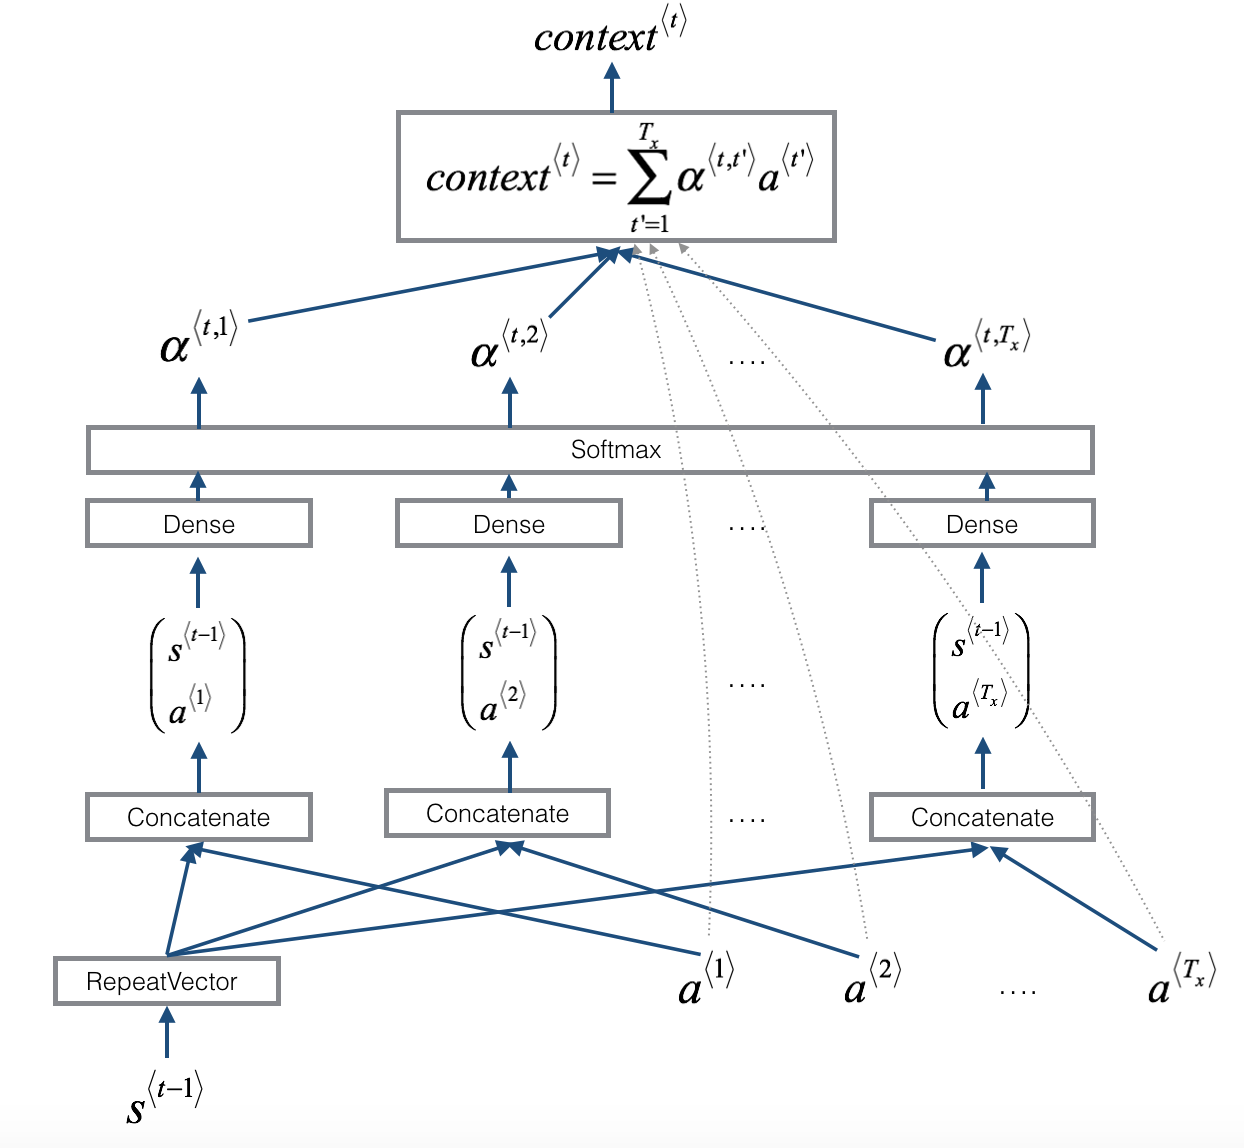

In [29]:
from IPython.display import Image
Image('/content/sample_data/attn_mechanism.png', width = 800)

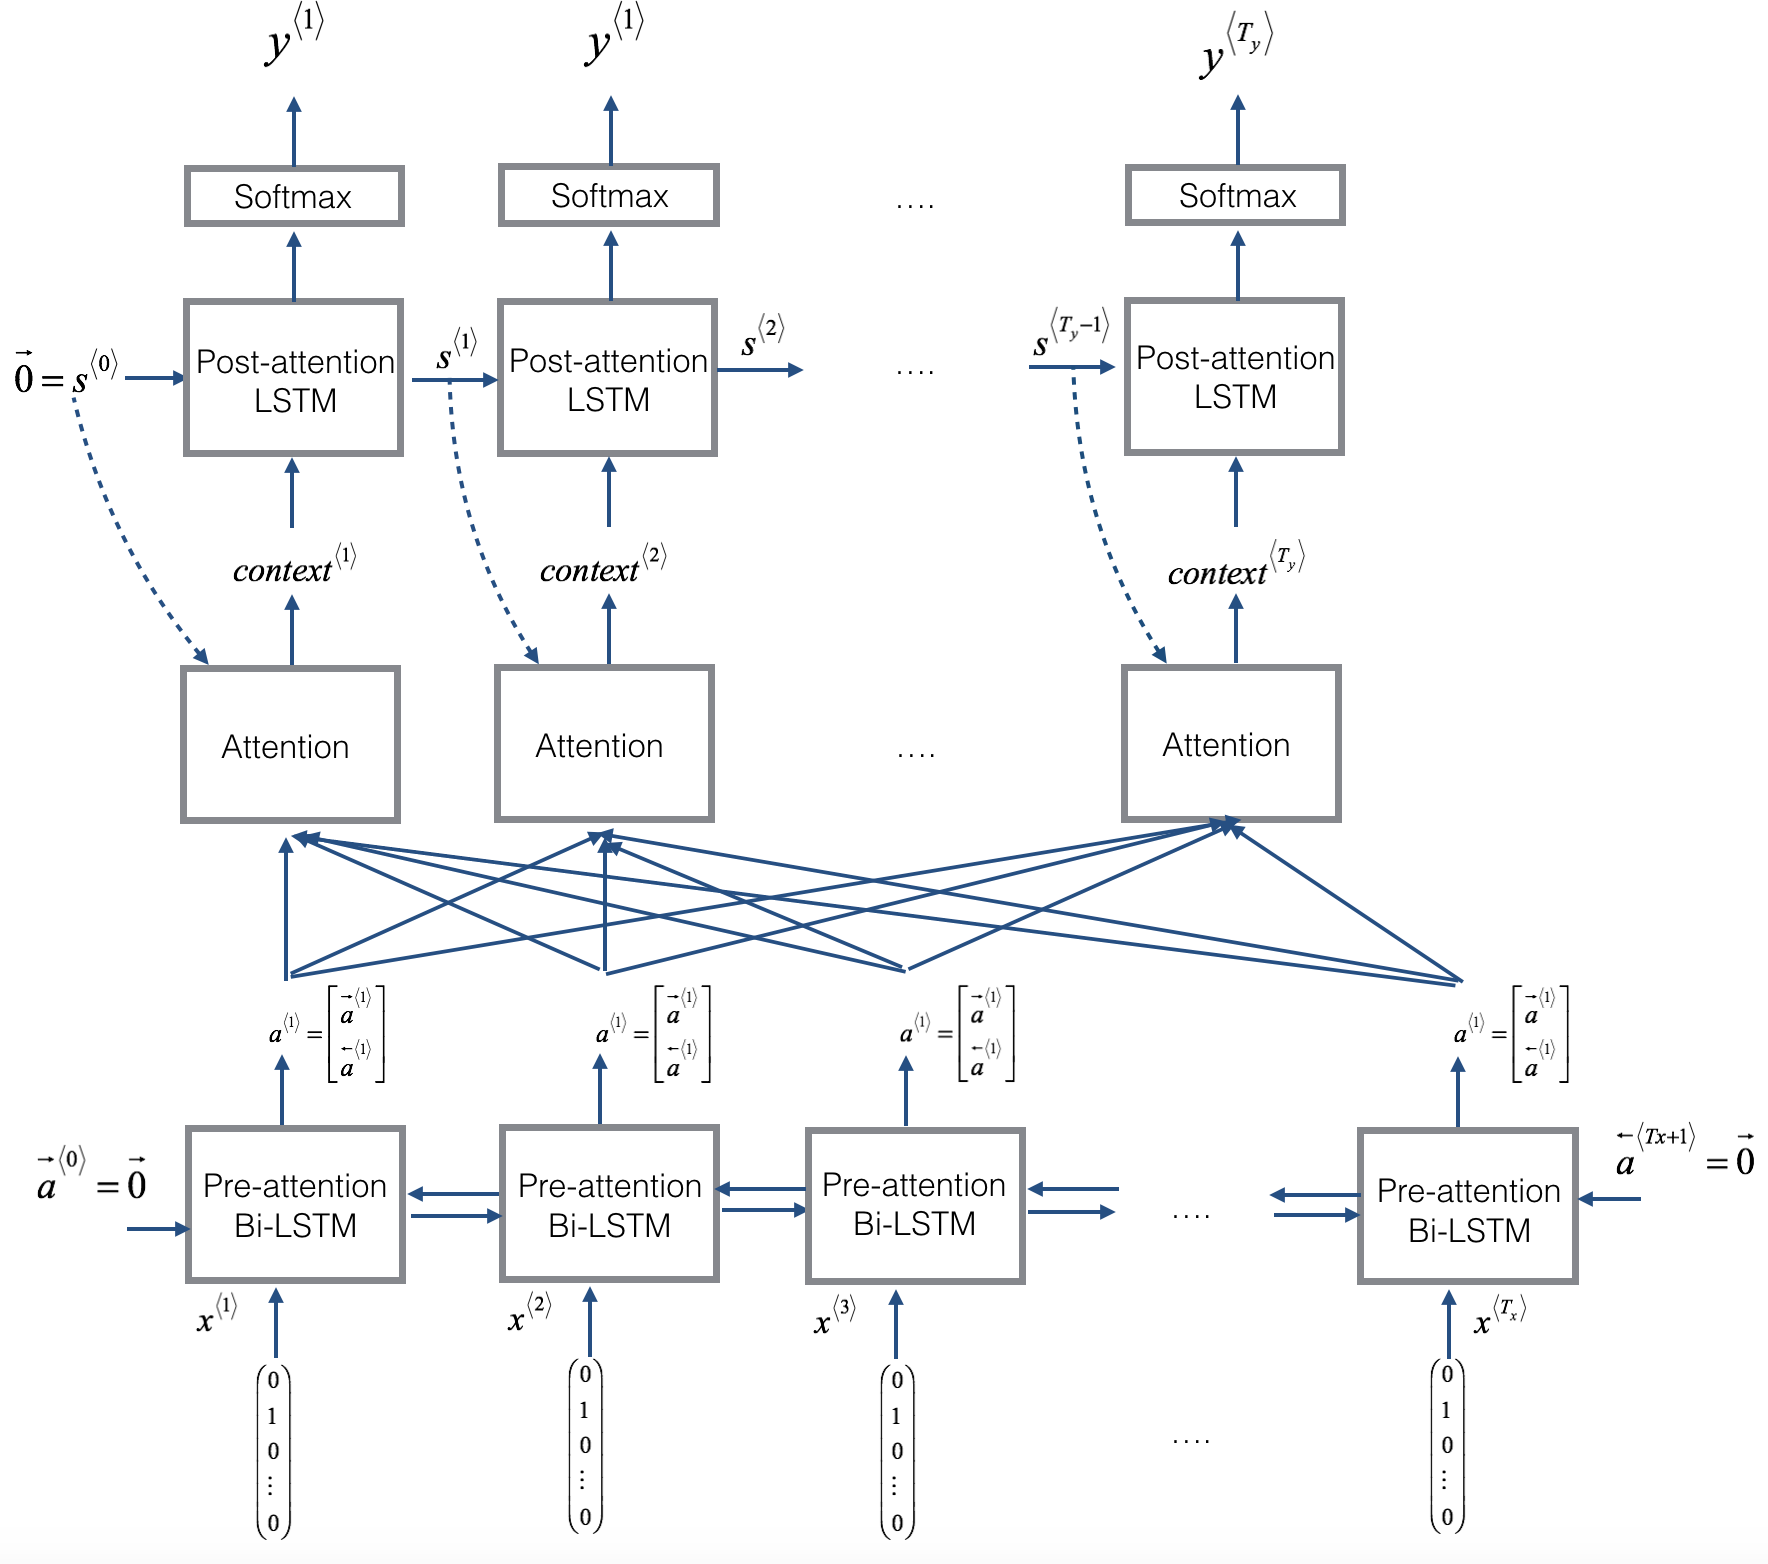

In [30]:
from IPython.display import Image
Image('/content/sample_data/attention_model.png',width = 800)


Here are some properties of the model that you may notice:

- There are two separate LSTMs in this model (see diagram on the left). Because the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism, we will call it *pre-attention* Bi-LSTM. The LSTM at the top of the diagram comes *after* the attention mechanism, so we will call it the *post-attention* LSTM. The pre-attention Bi-LSTM goes through $T_x$ time steps; the post-attention LSTM goes through $T_y$ time steps.

- The post-attention LSTM passes $s^{\langle t \rangle}, c^{\langle t \rangle}$ from one time step to the next. In the lecture videos, we were using only a basic RNN for the post-activation sequence model, so the state captured by the RNN output activations $s^{\langle t\rangle}$. But since we are using an LSTM here, the LSTM has both the output activation $s^{\langle t\rangle}$ and the hidden cell state $c^{\langle t\rangle}$. However, unlike previous text generation examples (such as Dinosaurus in week 1), in this model the post-activation LSTM at time $t$ does will not take the specific generated $y^{\langle t-1 \rangle}$ as input; it only takes $s^{\langle t\rangle}$ and $c^{\langle t\rangle}$ as input. We have designed the model this way, because (unlike language generation where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date.

- We use $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}; \overleftarrow{a}^{\langle t \rangle}]$ to represent the concatenation of the activations of both the forward-direction and backward-directions of the pre-attention Bi-LSTM.

- The diagram on the right uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times, and then `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ to compute $e^{\langle t, t'}$, which is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$. We'll explain how to use `RepeatVector` and `Concatenation` in Keras below.

Lets implement this model. You will start by implementing two functions: `one_step_attention()` and `model()`.

**1) `one_step_attention()`**: At step $t$, given all the hidden states of the Bi-LSTM ($[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$) and the previous hidden state of the second LSTM ($s^{<t-1>}$), `one_step_attention()` will compute the attention weights ($[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$) and output the context vector (see Figure  1 (right) for details):
$$context^{<t>} = \sum_{t' = 0}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$

Note that we are denoting the attention in this notebook $context^{\langle t \rangle}$. In the lecture videos, the context was denoted $c^{\langle t \rangle}$, but here we are calling it $context^{\langle t \rangle}$ to avoid confusion with the (post-attention) LSTM's internal memory cell variable, which is sometimes also denoted $c^{\langle t \rangle}$.
  
**2) `model()`**: Implements the entire model. It first runs the input through a Bi-LSTM to get back $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. Then, it calls `one_step_attention()` $T_y$ times (`for` loop). At each iteration of this loop, it gives the computed context vector $c^{<t>}$ to the second LSTM, and runs the output of the LSTM through a dense layer with softmax activation to generate a prediction $\hat{y}^{<t>}$.






<font color = green >

### Implement one_step_attention

</font>

The function `model()` will call the layers in `one_step_attention()` $T_y$ using a for-loop, and it is important that all $T_y$ copies have the same weights. I.e., it should not re-initiaiize the weights every time. In other words, all $T_y$ steps should have shared weights. Here's how you can implement layers with shareable weights in Keras:
1. Define the layer objects (as global variables).
2. Call these objects when propagating the input.


You may read keras documentation for target layers:
[RepeatVector()](https://keras.io/layers/core/#repeatvector)
[Concatenate()](https://keras.io/layers/merge/#concatenate),
[Dense()](https://keras.io/layers/core/#dense),
[Activation()](https://keras.io/layers/core/#activation),
[Dot()](https://keras.io/layers/merge/#dot).



In [15]:
def softmax(x, axis=1): # not sure why do we need custom implementation

    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [16]:
# Define layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1)
dotor = Dot(axes = 1)


Now you can use these layers to implement `one_step_attention()`. In order to propagate a Keras tensor object X through one of these layers, use `layer(X)` (or `layer([X,Y])` if it requires multiple inputs.), e.g. `densor(X)` will propagate X through the `Dense(1)` layer defined above.

In [17]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.

    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)

    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """


    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas,a])

    return context



<font color = green >

### Implement model

</font>




In [18]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

Now you can use these layers $T_y$ times in a `for` loop to generate the outputs, and their parameters will not be reinitialized. You will have to carry out the following steps:

1. Propagate the input into a [Bidirectional](https://keras.io/layers/wrappers/#bidirectional) [LSTM](https://keras.io/layers/recurrent/#lstm)
2. Iterate for $t = 0, \dots, T_y-1$:
    1. Call `one_step_attention()` on $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$ and $s^{<t-1>}$ to get the context vector $context^{<t>}$.
    2. Give $context^{<t>}$ to the post-attention LSTM cell. Remember pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM using `initial_state= [previous hidden state, previous cell state]`. Get back the new hidden state $s^{<t>}$ and the new cell state $c^{<t>}$.
    3. Apply a softmax layer to $s^{<t>}$, get the output.
    4. Save the output by adding it to the list of outputs.

3. Create your Keras model instance, it should have three inputs ("inputs", $s^{<0>}$ and $c^{<0>}$) and output the list of "outputs".

In [19]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """

    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0

    # Initialize empty list of outputs
    outputs = []

    ### START CODE HERE ###

    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences = True), input_shape=(m, Tx, 2*n_a))(X)  # default is merge_mode='concat'

    # Step 2: Iterate for Ty steps
    for t in range(Ty):

        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a,s)

        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])

        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)

        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)

    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X, s0, c0], outputs= outputs)

    ### END CODE HERE ###

    return model

Run the following cell to create your model.

In [20]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

Let's get a summary of the model to check if it matches the expected output.

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 37)]             0         []                            
                                                                                                  
 s0 (InputLayer)             [(None, 64)]                 0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 30, 64)               17920     ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 repeat_vector (RepeatVecto  (None, 30, 64)               0         ['s0[0][0]',              


<font color = blue >

### Expected result

</font>


<table>
    <tr>
        <td>
            **Total params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
        <tr>
        <td>
            **Trainable params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
            <tr>
        <td>
            **Non-trainable params:**
        </td>
        <td>
         0
        </td>
    </tr>
                    <tr>
        <td>
            **bidirectional_1's output shape **
        </td>
        <td>
         (None, 30, 64)  
        </td>
    </tr>
    <tr>
        <td>
            **repeat_vector_1's output shape **
        </td>
        <td>
         (None, 30, 64)
        </td>
    </tr>
                <tr>
        <td>
            **concatenate_1's output shape **
        </td>
        <td>
         (None, 30, 128)
        </td>
    </tr>
            <tr>
        <td>
            **attention_weights's output shape **
        </td>
        <td>
         (None, 30, 1)  
        </td>
    </tr>
        <tr>
        <td>
            **dot_1's output shape **
        </td>
        <td>
         (None, 1, 64)
        </td>
    </tr>
           <tr>
        <td>
            **dense_3's output shape **
        </td>
        <td>
         (None, 11)
        </td>
    </tr>
</table>



<font color = green >

### Setup optimizer

</font>




After creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using `categorical_crossentropy` loss, a custom [Adam](https://keras.io/optimizers/#adam) [optimizer](https://keras.io/optimizers/#usage-of-optimizers) (`learning rate = 0.005`, $\beta_1 = 0.9$, $\beta_2 = 0.999$, `decay = 0.01`)  and `['accuracy']` metrics:

In [23]:
### START CODE HERE ### (≈2 lines)
opt = Adam (lr=0.005, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
### END CODE HERE ###

The last step is to define all your inputs and outputs to fit the model:
- You already have X of shape $(m = 10000, T_x = 30)$ containing the training examples.
- You need to create `s0` and `c0` to initialize your `post_activation_LSTM_cell` with 0s.
- Given the `model()` you coded, you need the "outputs" to be a list of 11 elements of shape (m, T_y). So that: `outputs[i][0], ..., outputs[i][Ty]` represent the true labels (characters) corresponding to the $i^{th}$ training example (`X[i]`). More generally, `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [24]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))


<font color = green >

### Run training

</font>




Let's now fit the model and run it for one epoch.

In [25]:
model.fit([Xoh, s0, c0], outputs, epochs=20, batch_size=100)

Epoch 1/20
500/500 [==============================] - 73s 100ms/step - loss: 12.8571 - dense_2_loss: 0.6022 - dense_2_1_loss: 0.5633 - dense_2_2_loss: 1.4290 - dense_2_3_loss: 2.4210 - dense_2_4_loss: 0.4385 - dense_2_5_loss: 0.7687 - dense_2_6_loss: 2.3728 - dense_2_7_loss: 0.4606 - dense_2_8_loss: 1.4601 - dense_2_9_loss: 2.3410 - dense_2_accuracy: 0.7822 - dense_2_1_accuracy: 0.8506 - dense_2_2_accuracy: 0.3779 - dense_2_3_accuracy: 0.1328 - dense_2_4_accuracy: 0.9710 - dense_2_5_accuracy: 0.6387 - dense_2_6_accuracy: 0.1537 - dense_2_7_accuracy: 0.9953 - dense_2_8_accuracy: 0.3526 - dense_2_9_accuracy: 0.1359
Epoch 2/20
500/500 [==============================] - 50s 100ms/step - loss: 7.1296 - dense_2_loss: 0.0787 - dense_2_1_loss: 0.0778 - dense_2_2_loss: 0.9115 - dense_2_3_loss: 1.7924 - dense_2_4_loss: 0.0175 - dense_2_5_loss: 0.1457 - dense_2_6_loss: 1.4667 - dense_2_7_loss: 0.0120 - dense_2_8_loss: 0.8616 - dense_2_9_loss: 1.7656 - dense_2_accuracy: 0.9751 - dense_2_1_accuracy


<font color = green >

### Predict

</font>




In [31]:
samples_to_predict = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001',
            'March 3rd 2001', '1 March 2001',  '03 May 79', '5 Apr 2009', '21th of Aug 2016', '2007 Tue 10 Jul ', 'May 9  Saturday 2018']

s0 = np.zeros((len(samples_to_predict), n_s))
c0 = np.zeros((len(samples_to_predict), n_s))

X = np.array([string_to_int(i, Tx, human_vocab) for i in samples_to_predict])
Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
prediction = model.predict([Xoh, s0, c0])  # Note: It returns list (NOT ndarray) by Ty : [Ty, batch, m_vocabulary]
prediction = np.array(prediction).swapaxes(0, 1)  # Now it is (batch_size, Ty, m_vocabulary)
prediction_indices = np.argmax(prediction, axis=-1)

for i_sample in range(len(samples_to_predict)):
    output = [inv_machine_vocab[int(i)] for i in prediction_indices[i_sample]]
    print("source:", samples_to_predict[i_sample])
    print("output:", ''.join(output))

1/1 [==============================] - 7s 7s/step
source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-04-07
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-04-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-02-03
source: 1 March 2001
output: 2001-03-01
source: 03 May 79
output: 1979-05-05
source: 5 Apr 2009
output: 2009-04-05
source: 21th of Aug 2016
output: 2016-08-21
source: 2007 Tue 10 Jul 
output: 2017-07-02
source: May 9  Saturday 2018
output: 2018-01-09


You can also change these examples to test with your own examples. The next part will give you a better sense on what the attention mechanism is doing--i.e., what part of the input the network is paying attention to when generating a particular output character.


<font color = green >

### Visualizing Attention

</font>


Since the problem has a fixed output length of 10, it is also possible to carry out this task using 10 different softmax units to generate the 10 characters of the output. But one advantage of the attention model is that each part of the output (say the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what part of the output is looking at what part of the input.

Consider the task of translating "Saturday 9 May 2018" to "2018-05-09". If we visualize the computed $\alpha^{\langle t, t' \rangle}$ we get this:


Notice how the output ignores the "Saturday" portion of the input. None of the output timesteps are paying much attention to that portion of the input. We see also that 9 has been translated as 09 and May has been correctly translated into 05, with the output paying attention to the parts of the input it needs to to make the translation. The year mostly requires it to pay attention to the input's "18" in order to generate "2018."



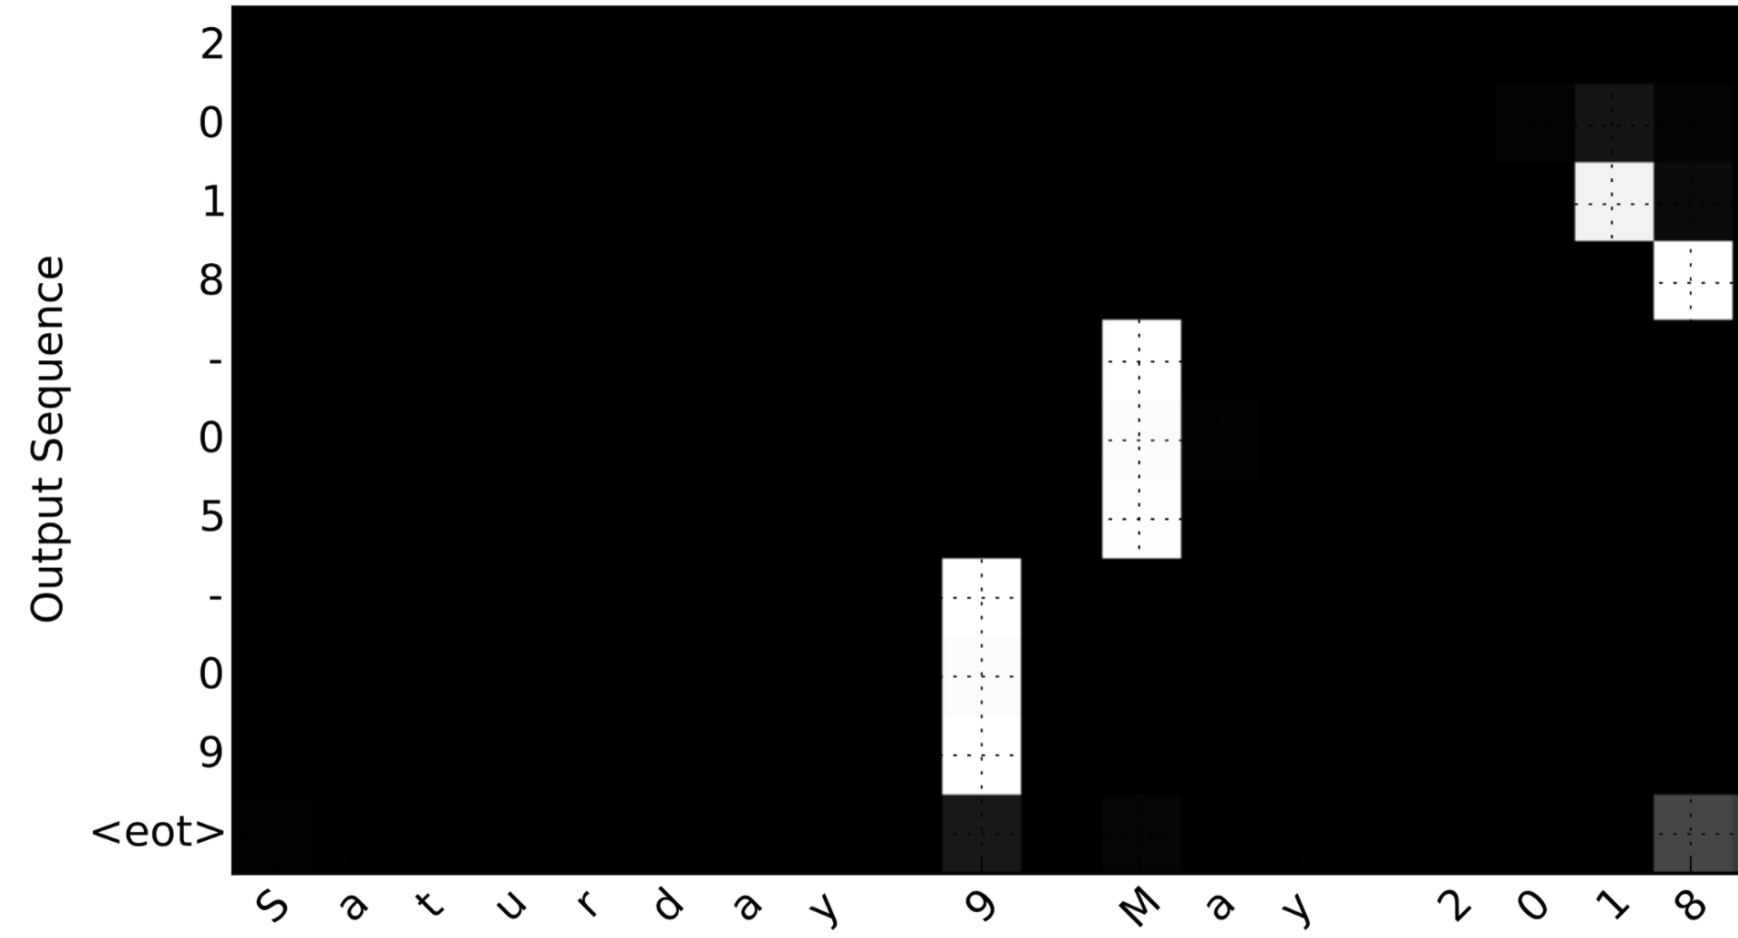

In [33]:
from IPython.display import Image
Image('/content/sample_data/date_attention.png', width= 800)


<font color = green >

### Getting the activations from the network

</font>

This allows to visualize the attention values in network.
We'll propagate an example through the network, then visualize the values of $\alpha^{\langle t, t' \rangle}$.

To figure out where the attention values are located, let's print a summary of the model .

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 37)]             0         []                            
                                                                                                  
 s0 (InputLayer)             [(None, 64)]                 0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 30, 64)               17920     ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 repeat_vector (RepeatVecto  (None, 30, 64)               0         ['s0[0][0]',              

Navigate through the output of `model.summary()` above. You can see that the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. Lets get the activations from this layer.

The function `plot_attention_map()` pulls out the attention values from your model and plots them.

In [35]:


def plot_attention_map(model, input_vocabulary, inv_output_vocabulary, text, n_s=128, num=6, Tx=30, Ty=10):
    """
    Plot the attention map.

    """
    attention_map = np.zeros((10, 30))
    Ty, Tx = attention_map.shape

    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.layers[num]

    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    r = f([encoded, s0, c0])

    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0, t_prime, 0]

        # Normalize attention map
    #     row_max = attention_map.max(axis=1)
    #     attention_map = attention_map / row_max[:, None]

    prediction = model.predict([encoded, s0, c0])

    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))

    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)

    # get the lengths of the string
    input_length = len(text)
    output_length = Ty

    # Plot the attention_map
    # plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    print ('attention_map:\n',attention_map)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    plt.show()

    return attention_map

def int_to_string(ints, inv_vocab):
    """
    Output a machine readable list of characters based on a list of indexes in the machine's vocabulary

    Arguments:
    ints -- list of integers representing indexes in the machine's vocabulary
    inv_vocab -- dictionary mapping machine readable indexes to machine readable characters

    Returns:
    l -- list of characters corresponding to the indexes of ints thanks to the inv_vocab mapping
    """

    l = [inv_vocab[i] for i in ints]
    return l

1/1 [==============================] - 0s 30ms/step
attention_map:
 [[3.73934046e-04 3.78430268e-04 3.73934046e-04 3.73934046e-04
  3.73934046e-04 3.73934046e-04 3.73934046e-04 3.73934046e-04
  3.73934046e-04 3.73934046e-04 3.73934046e-04 3.73934046e-04
  3.73934046e-04 3.73934046e-04 3.73934046e-04 3.73934046e-04
  2.43608672e-02 9.09003496e-01 3.15147378e-02 1.63736055e-03
  2.11414532e-03 2.88101682e-03 3.56182246e-03 4.01897402e-03
  4.22578165e-03 4.06283420e-03 3.30370991e-03 1.96629087e-03
  8.92182929e-04 4.69319057e-04]
 [1.39578816e-03 2.70845485e-03 8.68946314e-04 1.37415307e-04
  7.88633479e-05 7.78858594e-05 7.78858594e-05 7.78858594e-05
  7.78858594e-05 3.69085988e-04 6.03795575e-04 1.29155186e-03
  6.90118351e-04 2.30546459e-04 1.79527677e-03 8.03852454e-02
  5.29302478e-01 3.50123256e-01 2.04695892e-02 8.66284478e-04
  7.22747587e-04 6.93543290e-04 6.99064753e-04 7.14853464e-04
  7.32979854e-04 7.51889136e-04 7.89695769e-04 8.96388548e-04
  1.07679015e-03 1.29381346e-03

<ipython-input-35-5bf7a96b427f>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_text.append(int(np.argmax(prediction[i], axis=1)))


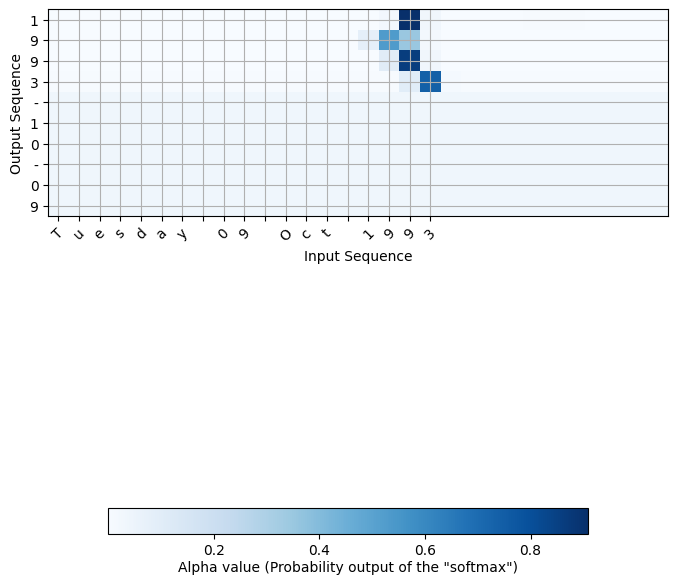

In [41]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)

On the generated plot you can observe the values of the attention weights for each character of the predicted output.

In the date translation application, you may observe that most of the time attention helps predict the year, and hasn't much impact on predicting the day/month.



[attention-model-intuition](https://www.coursera.org/learn/nlp-sequence-models/lecture/RDXpX/attention-model-intuition)

[attention-model](https://www.coursera.org/learn/nlp-sequence-models/lecture/lSwVa/attention-model)